In [468]:
import math

matrix =  [1, 1, 0, 0,
          0, 0, 0, 0, 
          0, 0, 1, 0, 
          0, 0, 0, 0]

# capture number of qubits needed for the system
maxIndex = len(matrix)

In [469]:
# Gera uma lista de binários do tamanho da matriz
def generateStates(size):
    state = []
    sizeRoot = int(math.sqrt(size))
    for i in range(size):
        state.append(bin(i))
    for i in range(size):
        state[i] = state[i][1:]
        state[i] = state[i].replace('b', '')
        if len (state[i]) < sizeRoot: state[i] = (add0(sizeRoot - (len (state[i])))) + state[i]
    return state

# Marca os estados de acordo com a matriz
def markStates(state):
    size = maxIndex
    for i in range(size):
        if matrix[i] == 1: state[i] = '-' + state[i]
        else: state[i] = '+' + state[i]
    return state

# Concatena 0's a esquerda das strings
def add0(n):
    if n == 0:
        return ('')
    else:
        return ('0' + (add0(n-1)))

# Retorna quantos 1's há em uma string
def howMany1(string):
    count = 0
    for i in range(len(string)):
        if string[i] == '1': count = count +1
    return count

# "multiplica por -1" uma string binária
def singFlip(string):
    if string[0] == '-': return ('+' + string[1:])
    else: return ('-' + string[1:])

def allPositive(state, size):
    for i in range(size):
        state[i] = '+' + state[i]
    return state

def whereIs1(string):
    locations = ''
    string = string[1:]
    for i in range(len(string)):
        if string[i] == '1': locations = locations + str(i)
    return locations

def flipSingOn(state, location):
    for i in range(maxIndex):
        if state[i][location] == '1':
            state[i] = singFlip(state[i])
    return state

def flipSingOn2(state, qubits):
    q0 = int(qubits[0])
    q1 = int(qubits[1])
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1':
            state[i] = singFlip(state[i])
    return state

def flipSingOn3(state, qubits):
    q0 = int(qubits[0])
    q1 = int(qubits[1])
    q2 = int(qubits[2])
    for i in range(maxIndex):
        if state[i][q0] == '1' and state[i][q1] == '1' and state[i][q2] == '1':
            state[i] = singFlip(state[i])
    return state

def runTo1(statusVector, n):
    theQubits = whereIs1(goalVector[n])
    print("theq %", theQubits)
    circuit.z(q[int(theQubits[0])]) # aplica z no qubit
    statusVector = flipSingOn(statusVector, int(theQubits[0])+1) # multiplica por -1 no vetor de status
    return statusVector

#============================
# MULTI-CONTROLLED GATES
#============================

def ccz(circ, q1, q2, q3, aux1):
# Apply Z-gate to a state controlled by 3 qubits
    circ.ccx(q1, q2, aux1)
    circ.cz(aux1, q3)
    # cleaning the aux bit
    circ.ccx(q1, q2, aux1)
    return circ

def cccz(circ, q1, q2, q3, q4, aux1, aux2):
# Apply Z-gate to a state controlled by 4 qubits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    circ.cz(aux2, q4)
    # cleaning the aux bits
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, aux1, aux2)
    return circ

def ccccx(circ, q1, q2, q3, q4, q5, aux1, aux2):
    circ.ccx(q1, q2, aux1)
    circ.ccx(q3, q4, aux2)
    circ.ccx(aux2, aux1, q5)
    # cleaning the aux bits
    circ.ccx(q3, q4, aux2)
    circ.ccx(q1, q2, aux1)
    return circ

In [470]:
goalVector = generateStates(maxIndex)
goalVector = markStates(goalVector)
statusVector = generateStates(maxIndex)
statusVector = allPositive(statusVector, maxIndex)

In [471]:
# Checando se objetivo[0] é -1
if goalVector[0][0] == '-':
    for i in range(maxIndex):
        goalVector[i] = singFlip(goalVector[i])

In [472]:
import qiskit as qk
nqubits = int(math.sqrt(maxIndex)) + 1
q = qk.QuantumRegister(nqubits)
c = qk.ClassicalRegister(1)
aux = qk.QuantumRegister(2) # Registrador auxiliar para o n-z-controlado
circuit = qk.QuantumCircuit(q, aux, c)
circuit.h(q)

['+0000', '+0001', '+0010', '+0011', '+0100', '+0101', '+0110', '+0111', '+1000', '+1001', '+1010', '+1011', '+1100', '+1101', '+1110', '+1111']
theq % 2
2
theq % 1
4
theq % 0
8
['+0000', '+0001', '-0010', '-0011', '-0100', '-0101', '+0110', '+0111', '-1000', '-1001', '+1010', '+1011', '+1100', '+1101', '-1110', '-1111']


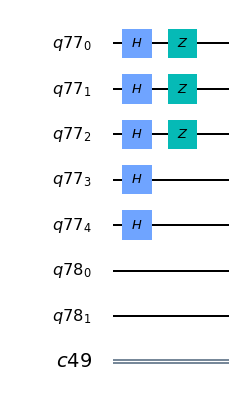

In [473]:
print(statusVector)
# print(goalVector)
for i in range(1,2):
    for n in range(maxIndex):
        if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 1):
            runTo1(statusVector, n)
            print(n)
    
#     circuit.barrier()
#     for n in range(maxIndex):
#         if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 2):
#             theQubits = whereIs1(goalVector[n])
#             circuit.cz(q[int(theQubits[0])], q[int(theQubits[1])])
#             statusVector = flipSingOn2(statusVector, theQubits)
# # #             statusVector = flipSingOn2(statusVector, int(theQubits[0])+1, int(theQubits[1])+1) # multiplica por -1 no vetor de status
# #             statusVector = flipSingOn(statusVector, int(theQubits[0])+1) # multiplica por -1 no vetor de status
# #             statusVector = flipSingOn(statusVector, int(theQubits[1])+1) # multiplica por -1 no vetor de status
#     circuit.barrier()
# #     for n in range(maxIndex):
# #         if (statusVector[n] != goalVector[n]) and (howMany1(goalVector[n]) == 3):
# #             theQubits = whereIs1(goalVector[n])
# #             print(theQubits)
# #             circuit = ccz(circuit, q[int(theQubits[0])], q[int(theQubits[1])], q[int(theQubits[2])], aux[0])
# #             statusVector = flipSingOn3(statusVector, theQubits)
# # #             statusVector = flipSingOn(statusVector, int(theQubits[0])+1) # multiplica por -1 no vetor de status
# # #             statusVector = flipSingOn(statusVector, int(theQubits[1])+1) # multiplica por -1 no vetor de status
# # #             statusVector = flipSingOn(statusVector, int(theQubits[2])+1) # multiplica por -1 no vetor de status
                

print(statusVector)
# print(goalVector)

circuit.draw(output='mpl')

In [474]:
ysV = generateStates(maxIndex)
ysV = allPositive(ysV, maxIndex)
print(ysV)
print(flipSingOn(ysV, 4))

['+0000', '+0001', '+0010', '+0011', '+0100', '+0101', '+0110', '+0111', '+1000', '+1001', '+1010', '+1011', '+1100', '+1101', '+1110', '+1111']
['+0000', '-0001', '+0010', '-0011', '+0100', '-0101', '+0110', '-0111', '+1000', '-1001', '+1010', '-1011', '+1100', '-1101', '+1110', '-1111']
